# Plot model diagram

In [892]:
from augur.frequency_estimators import TreeKdeFrequencies
from augur.titer_model import TiterCollection
from augur.utils import json_to_tree
import datetime
import json
import matplotlib as mpl
import matplotlib.dates as mdates
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from treetime.utils import numeric_date

%matplotlib inline

In [893]:
sns.set_style("ticks")
plt.style.use("huddlej")

In [894]:
mpl.rcParams['savefig.dpi'] = 200
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['font.weight'] = 300
mpl.rcParams['axes.labelweight'] = 300
mpl.rcParams['font.size'] = 14
mpl.rc('text', usetex=False)
#mpl.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

In [895]:
tip_size = 10
end_date = 2004.3

In [896]:
def float_to_datestring(time):
    """Convert a floating point date from TreeTime `numeric_date` to a date string
    """
    # Extract the year and remainder from the floating point date.
    year = int(time)
    remainder = time - year

    # Calculate the day of the year (out of 365 + 0.25 for leap years).
    tm_yday = int(remainder * 365.25)
    if tm_yday == 0:
        tm_yday = 1

    # Construct a date object from the year and day of the year.
    date = datetime.datetime.strptime("%s-%s" % (year, tm_yday), "%Y-%j")

    # Build the date string with zero-padded months and days.
    date_string = "%s-%.2i-%.2i" % (date.year, date.month, date.day)

    return date_string

In [897]:
def plot_tree_by_datetime(tree, color_by_trait=None, size_by_trait=None, initial_branch_width=5, tip_size=10,
              start_date=None, end_date=None, include_color_bar=False, ax=None, colorbar_ax=None,
              earliest_node_date=None, default_color="#cccccc", default_color_branch="#cccccc", override_y_values=None,
              cmap=None):
    """Plot a BioPython Phylo tree in the BALTIC-style.
    """
    # Plot H3N2 tree in BALTIC style from Bio.Phylo tree.
    if override_y_values is None:
        override_y_values = {}
        
    yvalues = [node.yvalue for node in tree.find_clades()]
    y_span = max(yvalues)
    y_unit = y_span / float(len(yvalues))

    # Setup colors.
    if color_by_trait:
        trait_name = color_by_trait
        
        if cmap is None:
            traits = [k.attr[trait_name] for k in tree.find_clades() if trait_name in k.attr]
            norm = mpl.colors.Normalize(min(traits), max(traits))
            cmap = mpl.cm.viridis

    #
    # Setup the figure grid.
    #

    if ax is None:
        if include_color_bar:
            fig = plt.figure(figsize=(8, 6), facecolor='w')
            gs = gridspec.GridSpec(2, 1, height_ratios=[14, 1], width_ratios=[1], hspace=0.1, wspace=0.1)
            ax = fig.add_subplot(gs[0])
            colorbar_ax = fig.add_subplot(gs[1])
        else:
            fig = plt.figure(figsize=(8, 4), facecolor='w')
            gs = gridspec.GridSpec(1, 1)
            ax = fig.add_subplot(gs[0])

    L=len([k for k in tree.find_clades() if k.is_terminal()])

    # Setup arrays for tip and internal node coordinates.
    tip_circles_x = []
    tip_circles_y = []
    tip_circles_color = []
    tip_circle_sizes = []
    node_circles_x = []
    node_circles_y = []
    node_circles_color = []
    node_line_widths = []
    node_line_segments = []
    node_line_colors = []
    branch_line_segments = []
    branch_line_widths = []
    branch_line_colors = []
    branch_line_labels = []

    for k in tree.find_clades(): ## iterate over objects in tree
        x=k.attr["collection_date_ordinal"] ## or from x position determined earlier
        
        if earliest_node_date and x < earliest_node_date:
            continue
        
        if k.name in override_y_values:
            y = override_y_values[k.name]
        else:
            y = y_span - k.yvalue ## get y position from .drawTree that was run earlier, but could be anything else

        if k.parent is None:
            xp = None
        else:
            xp=k.parent.attr["collection_date_ordinal"] ## get x position of current object's parent

        #if x==None: ## matplotlib won't plot Nones, like root
        #    x=0.0
        if xp==None:
            xp=x

        c = default_color
        if color_by_trait and trait_name in k.attr:
            if isinstance(cmap, dict):
                c = cmap[k.attr[trait_name]]
            else:
                c = cmap(norm(k.attr[trait_name]))

        branchWidth=initial_branch_width
        if k.is_terminal(): ## if leaf...            
            if size_by_trait is not None and size_by_trait in k.attr:
                s = (1000 * k.attr.get("projected_frequency", 0.01)) + 1
            else:
                s = tip_size ## tip size can be fixed

            tip_circle_sizes.append(s)
            tip_circles_x.append(x)
            tip_circles_y.append(y)
            tip_circles_color.append(c)
        else: ## if node...
            k_leaves = [child
                        for child in k.find_clades()
                        if child.is_terminal()]

            # Scale branch widths by the number of tips.
            branchWidth += initial_branch_width * len(k_leaves) / float(L)

            if len(k.clades)==1:
                node_circles_x.append(x)
                node_circles_y.append(y)
                node_circles_color.append(c)

            ax.plot([x,x],[y_span - k.clades[-1].yvalue, y_span - k.clades[0].yvalue], lw=branchWidth, color=default_color_branch, ls='-', zorder=9, solid_capstyle='round')

        branch_line_segments.append([(xp, y), (x, y)])
        branch_line_widths.append(branchWidth)
        branch_line_colors.append(default_color_branch)

    branch_lc = LineCollection(branch_line_segments, zorder=9)
    branch_lc.set_color(branch_line_colors)
    branch_lc.set_linewidth(branch_line_widths)
    branch_lc.set_label(branch_line_labels)
    branch_lc.set_linestyle("-")
    ax.add_collection(branch_lc)

    # Add circles for tips and internal nodes.
    tip_circle_sizes = np.array(tip_circle_sizes)
    ax.scatter(tip_circles_x, tip_circles_y, s=tip_circle_sizes, facecolor=tip_circles_color, edgecolor='none',zorder=11) ## plot circle for every tip
    ax.scatter(tip_circles_x, tip_circles_y, s=tip_circle_sizes*1.75, facecolor="#000000", edgecolor='none', zorder=10) ## plot black circle underneath
    ax.scatter(node_circles_x, node_circles_y, facecolor=node_circles_color, s=50, edgecolor='none', zorder=10, lw=2, marker='|') ## mark every node in the tree to highlight that it's a multitype tree

    #ax.set_ylim(-10, y_span - 300)

    ax.spines['top'].set_visible(False) ## no axes
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.tick_params(axis='y',size=0)
    ax.set_yticklabels([])

    if start_date:
        ax.set_xlim(left=start_date)

    if end_date:
        ax.set_xlim(right=end_date)

    if include_color_bar:
        cb1 = mpl.colorbar.ColorbarBase(
            colorbar_ax,
            cmap=cmap,
            norm=norm,
            orientation='horizontal'
        )
        cb1.set_label(color_by_trait)

    return ax, colorbar_ax

## Load trees

Load an auspice tree for both timepoint t and timepoint u. The first tree needs to be annotated with the projected frequency at time u and weighted distance to the future.

Both trees need to be annotated with amino acid sequences for the tips as an `aa_sequence` key in each tip's `attr` attribute.

In [939]:
with open("../results/auspice/flu_simulated_simulated_sample_1_2029-10-01_tree.json", "r") as fh:
    tree_json_for_t = json.load(fh)
    
tree_for_t = json_to_tree(tree_json_for_t)

In [940]:
tree_for_t

Clade(branch_length=0, clade=1281, name='NODE_0000002', numdate=2021.7606741025245, strain='NODE_0000002', yvalue=709.16530056349)

In [941]:
with open("../results/auspice/flu_simulated_simulated_sample_1_2030-10-01_tree.json", "r") as fh:
    tree_json_for_u = json.load(fh)

In [942]:
tree_for_u = json_to_tree(tree_json_for_u)

In [943]:
tree_for_u

Clade(branch_length=0, clade=1269, name='NODE_0000002', numdate=2022.8800298841593, strain='NODE_0000002', yvalue=699.4114999460708)

In [903]:
df = pd.read_csv(
    "../results/builds/natural/natural_sample_0_with_90_vpm_sliding/natural_sample_0_with_90_vpm_sliding_delta_frequency-cTiter-ne_star_forecast.tsv",
    sep="\t",
    parse_dates=["timepoint", "future_timepoint"]
)

In [904]:
df.head()

,timepoint,strain,frequency,weighted_distance_to_present,weighted_distance_to_future,fitness,projected_frequency,y,weighted_distance_to_future_by_delta_frequency-cTiter-ne_star,future_timepoint
0,1993-10-01,A/Netherlands/126/1993,0.009072,4.043942,7.439956,-2.324493,1.218509e-04,3.384775,3.384775,1994-10-01
1,1993-10-01,A/Netherlands/165/1993,0.015226,14.252614,17.811164,-7.842640,8.207491e-07,13.773169,13.773169,1994-10-01
2,1993-10-01,A/Netherlands/17/1993,0.000123,6.959802,10.578763,-3.064178,7.884778e-07,6.384514,6.384514,1994-10-01
3,1993-10-01,A/NewYork/754/1993,0.000549,4.924480,8.578773,-3.204311,3.059128e-06,4.384151,4.384151,1994-10-01
4,1993-10-01,A/NewYork/755/1993,0.020792,2.254680,5.600916,0.175177,3.401064e-03,1.382043,1.382043,1994-10-01


In [905]:
freq_bins = np.arange(0, 0.04, 0.001)

In [906]:
freq_bins

array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
       0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017,
       0.018, 0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026,
       0.027, 0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035,
       0.036, 0.037, 0.038, 0.039])

In [907]:
df.loc[df["timepoint"] == "2003-04-01", "projected_frequency"].describe()

count    3.790000e+02
mean     2.638522e-03
std      5.862588e-03
min      7.546541e-09
25%      6.490636e-06
50%      1.584250e-04
75%      1.531594e-03
max      3.468817e-02
Name: projected_frequency, dtype: float64

In [908]:
df.loc[df["timepoint"] == "2003-04-01", "projected_frequency"].shape

(379,)

In [909]:
1 / 379.0

0.002638522427440633

In [910]:
df["high_projected_frequency"] = df["projected_frequency"] >= 0.01

In [911]:
high_freqs_by_timepoint = df.groupby("timepoint")["high_projected_frequency"].aggregate(["count", "sum"]).reset_index()

In [912]:
high_freqs_by_timepoint.head()

,timepoint,count,sum
0,1993-10-01,54,19.0
1,1994-04-01,57,26.0
2,1994-10-01,56,12.0
3,1995-04-01,61,28.0
4,1995-10-01,64,5.0


In [913]:
high_freqs_by_timepoint["proportion"] =  high_freqs_by_timepoint["sum"] / high_freqs_by_timepoint["count"]

In [914]:
sum(high_freqs_by_timepoint["proportion"] >= 0.05)

33

In [915]:
high_freqs_by_timepoint.shape[0]

45

In [916]:
16.0 / 45

0.35555555555555557

In [917]:
33.0 / 45

0.7333333333333333

Text(0,0.5,'Timepoints')

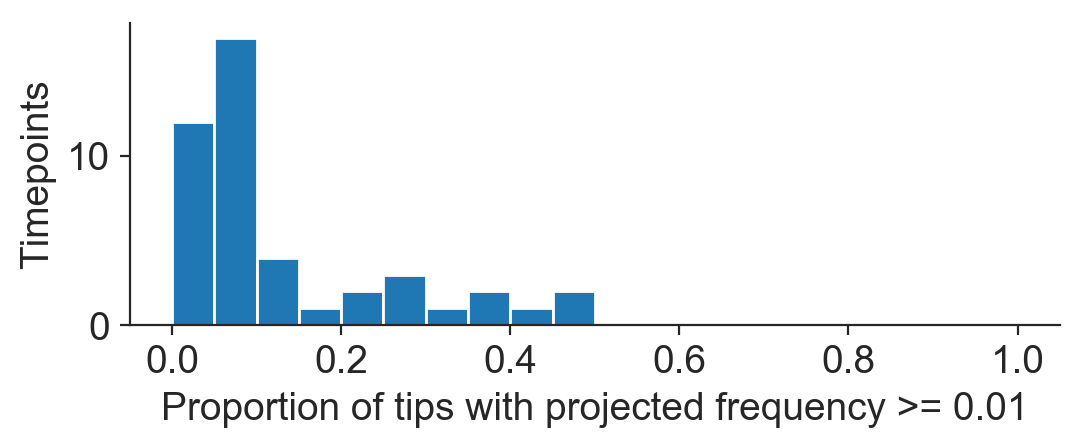

In [918]:
fig, ax = plt.subplots(1, 1, figsize=(6, 2))
ax.hist(high_freqs_by_timepoint["proportion"], bins=np.arange(0, 1.01, 0.05))
ax.set_xlabel("Proportion of tips with projected frequency >= 0.01")
ax.set_ylabel("Timepoints")

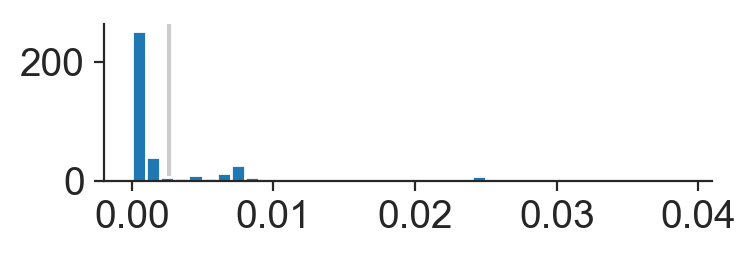

In [919]:
fig, ax = plt.subplots(1, 1, figsize=(4, 1.5))
ax.hist(df.loc[(df["timepoint"] == "2003-04-01"), "projected_frequency"], bins=freq_bins)
ax.axvline(x=1.0 / df.loc[df["timepoint"] == "2003-04-01", "projected_frequency"].shape[0], color="#cccccc", zorder=-10)
fig.tight_layout()

In [920]:
sum(df.loc[(df["timepoint"] == "2003-04-01"), "projected_frequency"] > 1.0 / 379)

84

In [921]:
84 / 379.0

0.22163588390501318

In [922]:
x_max = 30
y_max = 300
bins = np.arange(0, x_max + 1, 3)

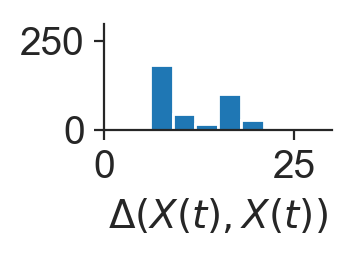

In [923]:
fig, ax = plt.subplots(1, 1, figsize=(2, 1.5))
ax.hist(df.loc[df["timepoint"] == "2003-04-01", "weighted_distance_to_present"], bins=bins)
ax.set_xlabel("$\Delta(X(t), X(t))$")
ax.set_xlim(0, x_max)
ax.set_ylim(0, y_max)
fig.tight_layout()

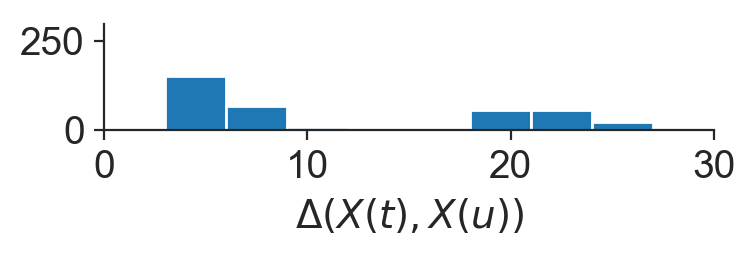

In [924]:
fig, ax = plt.subplots(1, 1, figsize=(4, 1.5))
ax.hist(df.loc[df["timepoint"] == "2003-04-01", "weighted_distance_to_future"], bins=bins)
ax.set_xlabel("$\Delta(X(t), X(u))$")
ax.set_xlim(0, x_max)
ax.set_ylim(0, y_max)
fig.tight_layout()

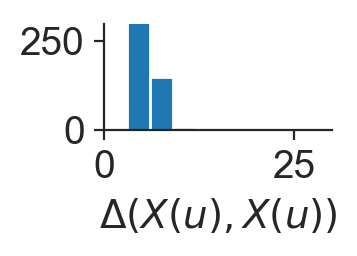

In [925]:
fig, ax = plt.subplots(1, 1, figsize=(2, 1.5))
ax.hist(df.loc[df["timepoint"] == "2004-04-01", "weighted_distance_to_present"], bins=bins)
ax.set_xlabel("$\Delta(X(u), X(u))$")
ax.set_xlim(0, x_max)
ax.set_ylim(0, y_max)
fig.tight_layout()

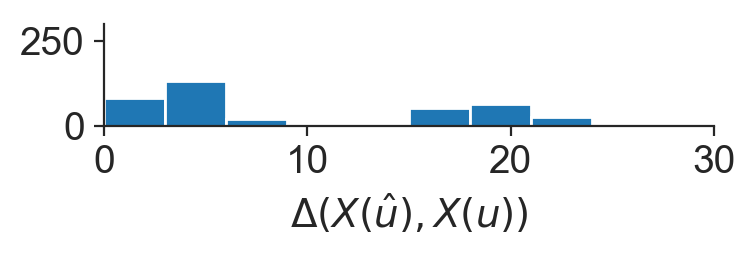

In [926]:
fig, ax = plt.subplots(1, 1, figsize=(4, 1.5))
ax.hist(df.loc[df["timepoint"] == "2003-04-01", "y"], bins=bins)
ax.set_xlabel("$\Delta(X(\hat{u}), X(u))$")
ax.set_xlim(0, x_max)
ax.set_ylim(0, y_max)
fig.tight_layout()

In [927]:
d_t_u = df.loc[df["timepoint"] == "2003-04-01", "weighted_distance_to_future"].values
d_u_hat_u = df.loc[df["timepoint"] == "2003-04-01", "y"].values
d_u_u = df.loc[df["timepoint"] == "2004-04-01", "weighted_distance_to_present"].values

In [928]:
d_t_u_value = (df.loc[df["timepoint"] == "2003-04-01", "frequency"].values * 
               df.loc[df["timepoint"] == "2003-04-01", "weighted_distance_to_future"].values).sum()

In [929]:
d_u_hat_u_value = (df.loc[df["timepoint"] == "2003-04-01", "projected_frequency"].values * 
                   df.loc[df["timepoint"] == "2003-04-01", "weighted_distance_to_future"].values).sum()

In [930]:
d_u_u_value = (df.loc[df["timepoint"] == "2004-04-01", "frequency"].values * 
               df.loc[df["timepoint"] == "2004-04-01", "weighted_distance_to_present"].values).sum()

In [931]:
df.loc[df["timepoint"] == "2003-04-01", "weighted_distance_to_future"].values

array([ 3.774618,  6.744404,  5.191728,  4.774634,  4.609291,  5.744388,
        5.504393,  4.764601,  5.781875, 21.332568, 25.329517, 21.324357,
       21.337612, 20.337596, 20.337596, 21.341063,  7.599126, 20.341797,
        4.609291, 21.240903, 23.334079, 20.636721, 20.341797, 23.334079,
       23.334079, 24.334095, 23.334079,  6.730653, 20.341797, 20.341797,
       24.316075, 20.636721, 23.334079, 20.636721, 20.341797, 23.334079,
       23.334079,  9.557406,  9.47496 , 23.334079, 20.636721, 20.636721,
       22.230023,  9.715738,  8.715722, 24.284719, 24.319423,  5.767595,
        5.5822  ,  3.774618,  3.784937,  7.320411, 20.330862, 21.288368,
       18.813518,  7.758343, 19.33758 , 19.33758 , 20.325936, 21.337612,
       21.337612, 20.325936, 20.330862, 19.33758 , 20.337596, 19.33758 ,
       22.282279, 19.33758 , 20.337596,  5.749016,  3.774618, 21.254317,
       20.337596, 21.337612, 21.337612, 21.330707, 11.714237,  5.749016,
        6.757698, 25.322995,  5.930705,  5.754298, 

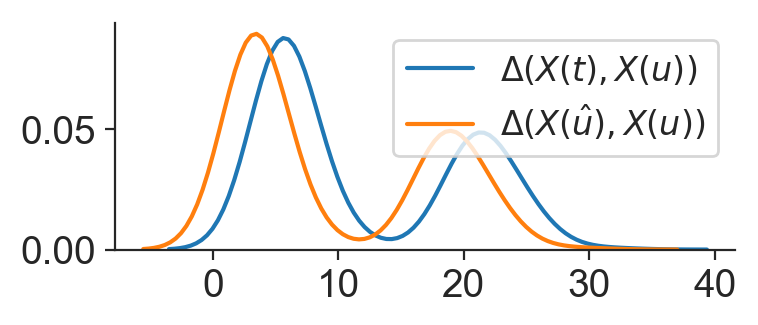

In [932]:
fig, ax = plt.subplots(1, 1, figsize=(4, 1.5))
sns.distplot(d_t_u, hist=False, ax=ax, label="$\Delta{(X(t), X(u))}$")
sns.distplot(d_u_hat_u, hist=False, ax=ax, label="$\Delta{(X(\hat{u}), X(u))}$")

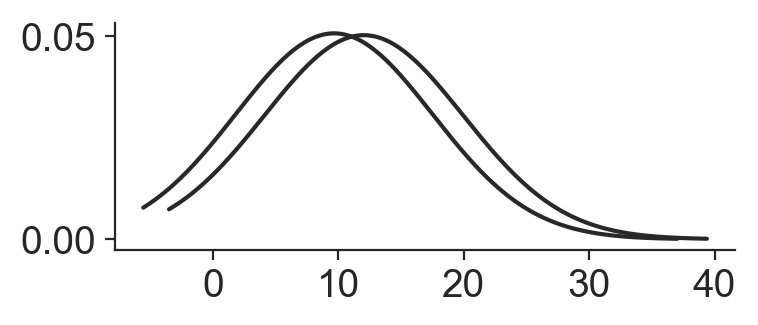

In [933]:
from scipy.stats import norm
fig, ax = plt.subplots(1, 1, figsize=(4, 1.5))
sns.distplot(d_t_u, hist=False, fit=norm, kde=False, ax=ax, label="$\Delta{(X(t), X(u))}$")
sns.distplot(d_u_hat_u, hist=False, fit=norm, kde=False, ax=ax, label="$\Delta{(X(\hat{u}), X(u))}$")

In [934]:
max_y_value

2068

In [935]:
for node in tree_for_u.find_clades():
    node.attr["collection_date"] = float_to_datestring(node.attr["num_date"])
    node.attr["collection_datetime"] = pd.to_datetime(node.attr["collection_date"])
    node.attr["collection_date_ordinal"] = node.attr["collection_datetime"].toordinal()
    
    if node.is_terminal() and not "projected_frequency" in node.attr:
        node.attr["projected_frequency"] = 0.0

In [936]:
end_date

2004.3

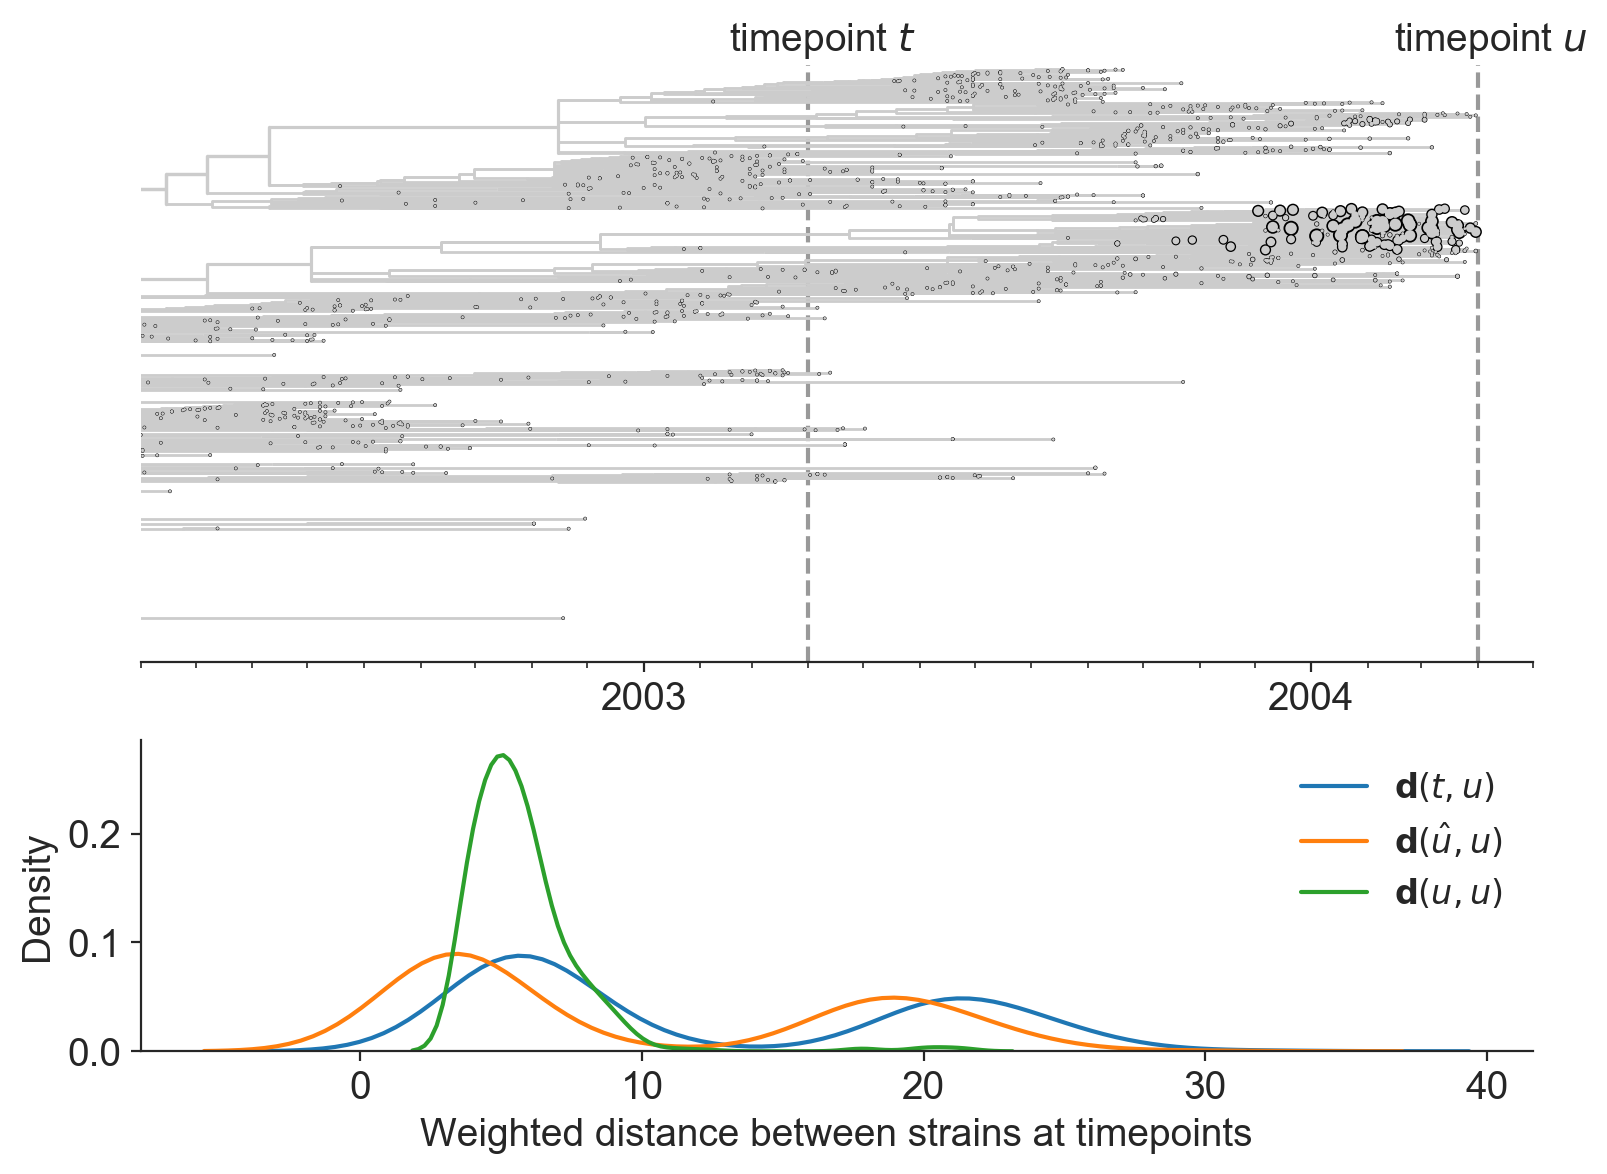

In [937]:
fig = plt.figure(figsize=(8, 6), facecolor='w')
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 0.5], width_ratios=[1], hspace=0.25, wspace=0.1)

tree_ax = fig.add_subplot(gs[0])    
tree_ax, colorbar_ax = plot_tree_by_datetime(
    tree_for_u,
    size_by_trait="projected_frequency",
    ax=tree_ax,
    start_date=pd.to_datetime("2002-04-01").toordinal(),
    end_date=pd.to_datetime("2004-05-01").toordinal(),
    tip_size=tip_size,
    initial_branch_width=1
)

years = mdates.YearLocator()
years_fmt = mdates.DateFormatter("%Y")
months = mdates.MonthLocator()
tree_ax.xaxis.set_major_locator(years)
tree_ax.xaxis.set_major_formatter(years_fmt)
tree_ax.xaxis.set_minor_locator(months)
tree_ax.format_xdata = mdates.DateFormatter("%b %Y")

tree_ax.text(0.49, 1.0, "timepoint $t$", 
             horizontalalignment='center',
             verticalalignment='center',
             transform=tree_ax.transAxes,
             fontdict={"fontsize": 14})
tree_ax.text(0.97, 1.0, "timepoint $u$", 
             horizontalalignment='center',
             verticalalignment='center',
             transform=tree_ax.transAxes,
             fontdict={"fontsize": 14})
tree_ax.axvline(x=pd.to_datetime("2003-04-01").toordinal(), ymax=0.96, color="#999999", linestyle="--")
tree_ax.axvline(x=pd.to_datetime("2004-04-01").toordinal(), ymax=0.96, color="#999999", linestyle="--")
fig.autofmt_xdate(rotation=0, ha="center")

density_ax = fig.add_subplot(gs[1])
sns.distplot(d_t_u, hist=False, ax=density_ax, label=r"$\mathbf{d}(t, u)$")
sns.distplot(d_u_hat_u, hist=False, ax=density_ax, label=r"$\mathbf{d}(\hat{u}, u)$")
sns.distplot(d_u_u, hist=False, ax=density_ax, label=r"$\mathbf{d}(u, u)$")
density_ax.set_xlabel("Weighted distance between strains at timepoints")
density_ax.set_ylabel("Density")
density_ax.legend(frameon=False)

gs.tight_layout(fig, h_pad=0.5)

#plt.savefig("../manuscript/figures/distance-based-fitness-model.png")

## t-SNE to cluster sequences

In [854]:
nodes = [node for node in tree_for_u.find_clades(terminal=True)
         if node.attr["projected_frequency"] > 0 or node.attr["num_date"] > 2003.25]

In [855]:
total_nodes = len(nodes)

In [856]:
total_nodes

1100

In [857]:
distances = np.zeros((total_nodes, total_nodes))
for i, node_a in enumerate(nodes):
    node_a_array = np.frombuffer(node_a.attr["aa_sequence"].encode(), 'S1')
    
    for j, node_b in enumerate(nodes):
        if node_a.name == node_b.name:
            distance = 0.0
        elif distances[j, i] > 0:
            distance = distances[j, i]
        else:
            node_b_array = np.frombuffer(node_b.attr["aa_sequence"].encode(), 'S1')
            distance = (node_a_array != node_b_array).sum()
            
        distances[i, j] = distance

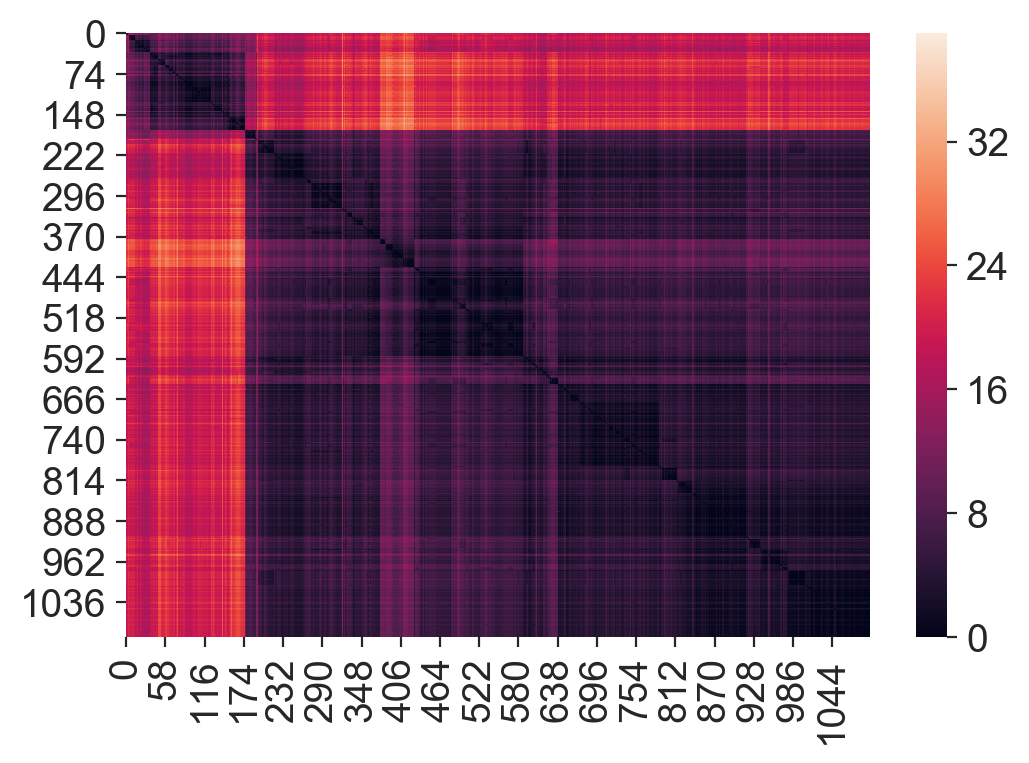

In [858]:
sns.heatmap(distances)

In [859]:
X_embedded_1d = TSNE(n_components=1, learning_rate=300).fit_transform(distances)

(-0.005, 0.005)

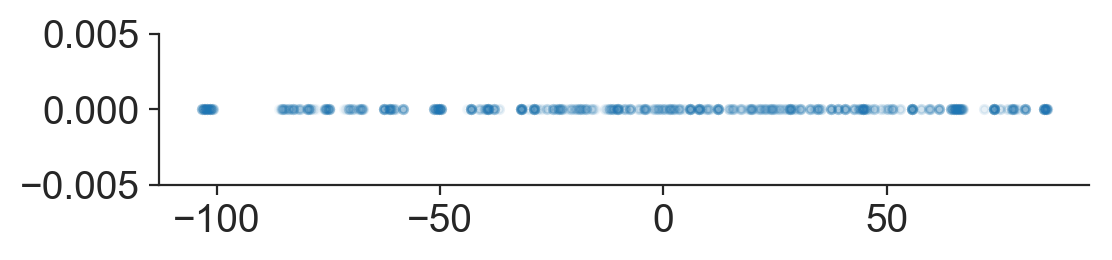

In [860]:
fig, ax = plt.subplots(1, 1, figsize=(6, 1))
ax.plot(X_embedded_1d[:, 0], np.zeros_like(X_embedded_1d[:, 0]), ".", alpha=0.05)
ax.set_ylim(-0.005, 0.005)

In [861]:
rank_records = []
for i, node in enumerate(nodes):
    node.attr["rank"] = X_embedded_1d[i, 0]
    
    rank_records.append({
        "strain": node.name,
        "rank": node.attr["rank"]
    })

In [862]:
rank_df = pd.DataFrame(rank_records)

In [863]:
rank_df.head()

,rank,strain
0,-86.058449,A/Kyongbuk/304/2002
1,-69.645866,A/Philippines/PH-1159050/2002
2,-69.365486,A/Sofia/344/2002
3,-69.697708,A/Sofia/343/2002
4,-71.401871,A/Paris/207/2002


In [864]:
rank_normalizer = mpl.colors.Normalize(rank_df["rank"].min(), rank_df["rank"].max())

In [865]:
rank_normalizer

In [866]:
rank_df["color"] = rank_df["rank"].apply(rank_normalizer).apply(lambda value: mpl.cm.viridis(value))

In [867]:
rank_df.head()

,rank,strain,color
0,-86.058449,A/Kyongbuk/304/2002,"(0.283072, 0.130895, 0.449241, 1.0)"
1,-69.645866,A/Philippines/PH-1159050/2002,"(0.263663, 0.237631, 0.518762, 1.0)"
2,-69.365486,A/Sofia/344/2002,"(0.263663, 0.237631, 0.518762, 1.0)"
3,-69.697708,A/Sofia/343/2002,"(0.263663, 0.237631, 0.518762, 1.0)"
4,-71.401871,A/Paris/207/2002,"(0.26658, 0.228262, 0.514349, 1.0)"


In [868]:
cmap

In [869]:
for node in tree_for_u.find_clades(terminal=True):
    if node.attr["num_date"] > 2003.25:
        node.attr["projected_frequency"] = 0.01
        
    if node.attr["projected_frequency"] < 1e-4:
        node.attr["projected_frequency_bin"] = "0"
    elif 1e-4 <= node.attr["projected_frequency"] < 0.01:
        node.attr["projected_frequency_bin"] = "1"
    elif 0.01 <= node.attr["projected_frequency"] < 0.02:
        node.attr["projected_frequency_bin"] = "2"
    else:
        node.attr["projected_frequency_bin"] = "3"

In [870]:
freq_bin_cmap = dict([(str(i), cmap(i)) for i in range(4)])

In [871]:
freq_bin_cmap

{'0': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
 '1': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0),
 '2': (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
 '3': (1.0, 0.7333333333333333, 0.47058823529411764, 1.0)}

## Load frequencies

Load tip frequencies from auspice. These should include a `projected_pivot` key and one or more pivots after that timepoint for each tip.

In [872]:
numeric_date(pd.to_datetime("2000-04-01"))

2000.2518822724162

In [873]:
kde_frequencies = TreeKdeFrequencies(
    include_internal_nodes=False,
    start_date=numeric_date(pd.to_datetime("2001-04-01")),
    end_date=numeric_date(pd.to_datetime("2004-04-01"))
)
frequencies = kde_frequencies.estimate(tree_for_u)

In [874]:
len(frequencies)

2068

In [876]:
pivots = kde_frequencies.pivots

In [877]:
pivots

array([2001.25, 2001.33, 2001.42, 2001.5 , 2001.58, 2001.67, 2001.75,
       2001.83, 2001.92, 2002.  , 2002.08, 2002.17, 2002.25, 2002.33,
       2002.42, 2002.5 , 2002.58, 2002.67, 2002.75, 2002.83, 2002.92,
       2003.  , 2003.08, 2003.17, 2003.25, 2003.33, 2003.42, 2003.5 ,
       2003.58, 2003.67, 2003.75, 2003.83, 2003.92, 2004.  , 2004.08,
       2004.17, 2004.25])

In [878]:
frequency_records = []
for sample, sample_frequencies in frequencies.items():
    for pivot, sample_frequency in zip(kde_frequencies.pivots, sample_frequencies):
        frequency_records.append({
            "strain": sample,
            "timepoint": float_to_datestring(pivot),
            "pivot": pivot,
            "frequency": sample_frequency
        })

In [879]:
frequency_df = pd.DataFrame(frequency_records)

In [880]:
frequency_df["timepoint"] = pd.to_datetime(frequency_df["timepoint"])

In [881]:
frequency_df.head()

,frequency,pivot,strain,timepoint
0,0.0,2001.25,A/Sichuan/137/1998,2001-04-01
1,0.0,2001.33,A/Sichuan/137/1998,2001-05-01
2,0.0,2001.42,A/Sichuan/137/1998,2001-06-01
3,0.0,2001.50,A/Sichuan/137/1998,2001-07-01
4,0.0,2001.58,A/Sichuan/137/1998,2001-08-01


In [882]:
rank_frequency_df = frequency_df.merge(
    rank_df,
    on="strain"
).sort_values(["rank", "strain", "timepoint"])

In [883]:
rank_frequency_df.head()

,frequency,pivot,strain,timepoint,rank,color
27824,4.658636e-203,2001.25,A/NewCaledonia/20/2003,2001-04-01,-103.338089,"(0.267004, 0.004874, 0.329415, 1.0)"
27825,3.719851e-192,2001.33,A/NewCaledonia/20/2003,2001-05-01,-103.338089,"(0.267004, 0.004874, 0.329415, 1.0)"
27826,8.784856e-179,2001.42,A/NewCaledonia/20/2003,2001-06-01,-103.338089,"(0.267004, 0.004874, 0.329415, 1.0)"
27827,3.406724e-167,2001.50,A/NewCaledonia/20/2003,2001-07-01,-103.338089,"(0.267004, 0.004874, 0.329415, 1.0)"
27828,5.055354e-156,2001.58,A/NewCaledonia/20/2003,2001-08-01,-103.338089,"(0.267004, 0.004874, 0.329415, 1.0)"


In [884]:
len(pivots)

37

In [885]:
pivots

array([2001.25, 2001.33, 2001.42, 2001.5 , 2001.58, 2001.67, 2001.75,
       2001.83, 2001.92, 2002.  , 2002.08, 2002.17, 2002.25, 2002.33,
       2002.42, 2002.5 , 2002.58, 2002.67, 2002.75, 2002.83, 2002.92,
       2003.  , 2003.08, 2003.17, 2003.25, 2003.33, 2003.42, 2003.5 ,
       2003.58, 2003.67, 2003.75, 2003.83, 2003.92, 2004.  , 2004.08,
       2004.17, 2004.25])

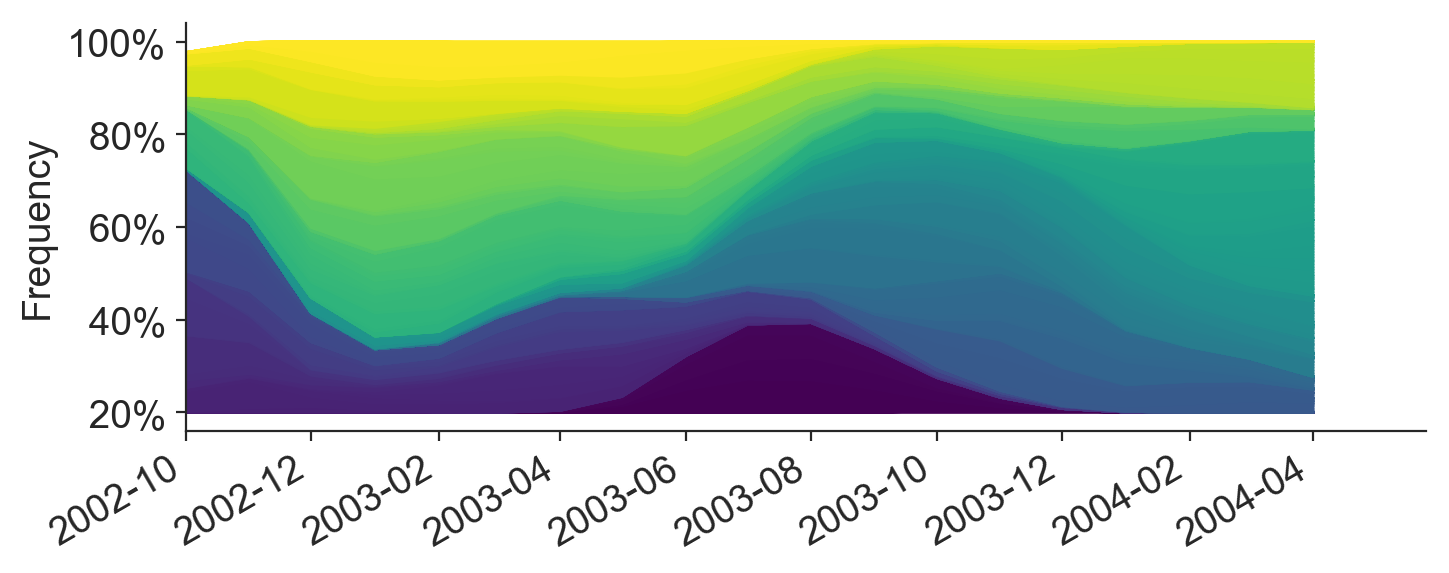

In [886]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
baseline = np.zeros_like(pivots)

for strain, strain_df in rank_frequency_df.groupby(["rank", "strain"]):
    ax.fill_between(strain_df["timepoint"].values, baseline, baseline + strain_df["frequency"].values, color=strain_df["color"].unique()[0])
    baseline = baseline + strain_df["frequency"].values

ax.set_xlim(left=pd.to_datetime("2002-10-01"))
ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in [0, 0.2, 0.4, 0.6, 0.8, 1.0]])

ax.set_ylabel("Frequency")

fig.autofmt_xdate()

## Plot tree

In [504]:
cmap = plt.get_cmap("tab20")

ValueError: min() arg is an empty sequence

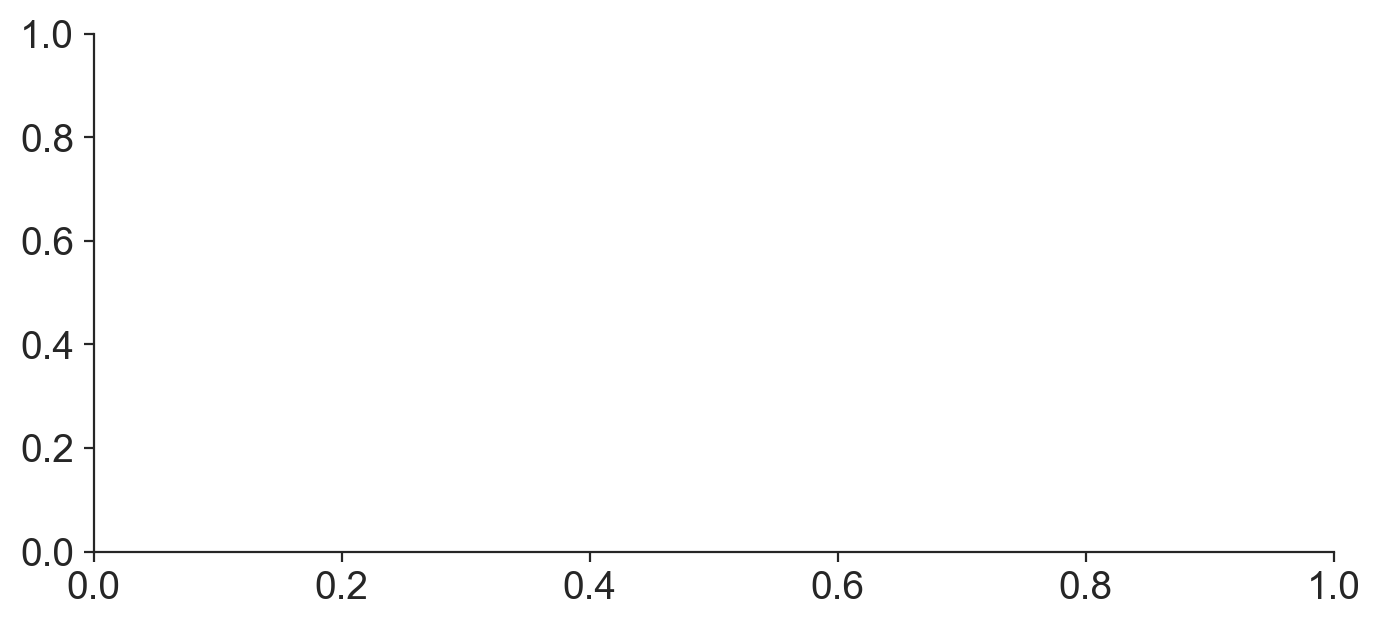

In [938]:
fig = plt.figure(figsize=(8, 8), facecolor='w')
gs = gridspec.GridSpec(3, 1, height_ratios=[1, 0.5, 0.5], width_ratios=[1], hspace=0.25, wspace=0.1)

# Tree plot

tree_ax = fig.add_subplot(gs[0])    
tree_ax, colorbar_ax = plot_tree_by_datetime(
    tree_for_u,
    color_by_trait="rank",
    size_by_trait="projected_frequency",
    ax=tree_ax,
    start_date=pd.to_datetime("2002-04-01").toordinal(),
    end_date=pd.to_datetime("2004-05-01").toordinal(),
    tip_size=tip_size,
    initial_branch_width=1
)

years = mdates.YearLocator()
years_fmt = mdates.DateFormatter("%Y")
months = mdates.MonthLocator()
tree_ax.xaxis.set_major_locator(years)
tree_ax.xaxis.set_major_formatter(years_fmt)
tree_ax.xaxis.set_minor_locator(months)
tree_ax.format_xdata = mdates.DateFormatter("%b %Y")

tree_ax.text(0.49, 1.0, "timepoint $t$", 
             horizontalalignment='center',
             verticalalignment='center',
             transform=tree_ax.transAxes,
             fontdict={"fontsize": 14})
tree_ax.text(0.97, 1.0, "timepoint $u$", 
             horizontalalignment='center',
             verticalalignment='center',
             transform=tree_ax.transAxes,
             fontdict={"fontsize": 14})
tree_ax.axvline(x=pd.to_datetime("2003-04-01").toordinal(), ymax=0.96, color="#999999", linestyle="--")
tree_ax.axvline(x=pd.to_datetime("2004-04-01").toordinal(), ymax=0.96, color="#999999", linestyle="--")

# Frequency plot(s)

frequency_ax = fig.add_subplot(gs[1])
baseline = np.zeros_like(pivots)
for strain, strain_df in rank_frequency_df.groupby(["rank", "strain"]):
    frequency_ax.fill_between(
        strain_df["timepoint"].values,
        baseline, baseline + strain_df["frequency"].values,
        color=strain_df["color"].unique()[0]
    )
    baseline = baseline + strain_df["frequency"].values

frequency_ax.axvline(x=pd.to_datetime("2003-04-01"), color="#999999", linestyle="--")
frequency_ax.axvline(x=pd.to_datetime("2004-04-01"), color="#999999", linestyle="--")    

ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in [0, 0.2, 0.4, 0.6, 0.8, 1.0]])
ax.set_ylabel("Frequency")

frequency_ax.set_xlim(
    pd.to_datetime("2002-04-01"),
    pd.to_datetime("2004-05-01")
)

frequency_ax.xaxis.set_major_locator(years)
frequency_ax.xaxis.set_major_formatter(years_fmt)
frequency_ax.xaxis.set_minor_locator(months)
frequency_ax.format_xdata = mdates.DateFormatter("%b %Y")

# Density plots

density_ax = fig.add_subplot(gs[2])
sns.distplot(d_t_u, hist=False, ax=density_ax, label=r"$\mathbf{d}(t, u)$", color=cmap(2))
sns.distplot(d_u_hat_u, hist=False, ax=density_ax, label=r"$\mathbf{d}(\hat{u}, u)$", color=cmap(1))
sns.distplot(d_u_u, hist=False, ax=density_ax, label=r"$\mathbf{d}(u, u)$", color=cmap(0))

density_ax.axvline(x=d_t_u_value, color=cmap(2), linestyle="--", alpha=0.75)
density_ax.axvline(x=d_u_hat_u_value, color=cmap(1), linestyle="--", alpha=0.75)
density_ax.axvline(x=d_u_u_value, color=cmap(0), linestyle="--", alpha=0.75)

density_ax.text(
    0.01,
    0.95,
    "$d(t, u) = %.2f$" % d_t_u_value,
    horizontalalignment='left',
    verticalalignment='center',
    transform=density_ax.transAxes
)
density_ax.text(
    0.01,
    0.80,
    "$d(\hat{u}, u) = %.2f$" % d_u_hat_u_value,
    horizontalalignment='left',
    verticalalignment='center',
    transform=density_ax.transAxes
)
density_ax.text(
    0.01,
    0.65,
    "$d(u, u) = %.2f$" % d_u_u_value,
    horizontalalignment='left',
    verticalalignment='center',
    transform=density_ax.transAxes
)

density_ax.set_xlabel("Weighted distance between strains at timepoints")
density_ax.set_ylabel("Density")
density_ax.legend(frameon=False)

fig.autofmt_xdate(rotation=0, ha="center")
gs.tight_layout(fig, h_pad=1.0)

#plt.savefig("../manuscript/figures/distance-based-fitness-model.png")

In [888]:
(d_u_hat_u_value - d_u_u_value) / d_t_u_value

-0.06333168789839866

In [889]:
(d_t_u_value - d_u_u_value) / d_t_u_value

0.449491878743931

In [523]:
d_u_hat_u_value - d_t_u_value

-5.161625271329987

In [524]:
d_u_hat_u_value / d_t_u_value

0.48717643335767036

In [531]:
d_t_u_values = []
d_u_hat_u_values = []
d_u_u_values = []
offset = pd.DateOffset(months=12)

for timepoint in df.query("timepoint <= '2014-10-01'").timepoint.drop_duplicates():
    future_timepoint = timepoint + offset
    d_t_u_values.append(
        (df.loc[df["timepoint"] == timepoint, "frequency"].values * 
         df.loc[df["timepoint"] == timepoint, "weighted_distance_to_future"].values).sum()
    )
    
    d_u_hat_u_values.append(
        (df.loc[df["timepoint"] == timepoint, "projected_frequency"].values * 
         df.loc[df["timepoint"] == timepoint, "weighted_distance_to_future"].values).sum()
    )
    
    d_u_u_values.append(
        (df.loc[df["timepoint"] == future_timepoint, "frequency"].values * 
         df.loc[df["timepoint"] == future_timepoint, "weighted_distance_to_present"].values).sum()
    )

In [535]:
values_by_timepoint = pd.DataFrame({"d_t_u": d_t_u_values, "d_u_hat_u": d_u_hat_u_values, "d_u_u": d_u_u_values})

In [536]:
values_by_timepoint.head()

,d_t_u,d_u_hat_u,d_u_u
0,5.890696,4.992871,7.061616
1,9.835388,9.061510,7.369828
2,12.238682,11.611282,10.002880
3,12.531195,12.006846,7.194453
4,15.302754,10.502533,8.376733


In [546]:
values_by_timepoint["timepoint"] = df.query("timepoint <= '2014-10-01'").timepoint.drop_duplicates().values

In [537]:
values_by_timepoint["model_distance"] = (values_by_timepoint["d_u_hat_u"] - values_by_timepoint["d_u_u"]) / values_by_timepoint["d_t_u"]

In [538]:
values_by_timepoint["naive_distance"] = (values_by_timepoint["d_t_u"] - values_by_timepoint["d_u_u"]) / values_by_timepoint["d_t_u"]

In [563]:
values_by_timepoint["model_centered_by_naive"] = values_by_timepoint["d_u_hat_u"] - values_by_timepoint["d_t_u"]

In [565]:
values_by_timepoint["model_normalized_by_naive"] = values_by_timepoint["d_u_hat_u"] / values_by_timepoint["d_t_u"]

In [566]:
values_by_timepoint.head()

,d_t_u,d_u_hat_u,d_u_u,model_distance,naive_distance,timepoint,model_centered_by_naive,model_normalized_by_naive
0,5.890696,4.992871,7.061616,-0.351189,-0.198775,1993-10-01,-0.897825,0.847586
1,9.835388,9.061510,7.369828,0.172000,0.250682,1994-04-01,-0.773878,0.921317
2,12.238682,11.611282,10.002880,0.131420,0.182683,1994-10-01,-0.627400,0.948736
3,12.531195,12.006846,7.194453,0.384033,0.425877,1995-04-01,-0.524349,0.958157
4,15.302754,10.502533,8.376733,0.138916,0.452600,1995-10-01,-4.800221,0.686317


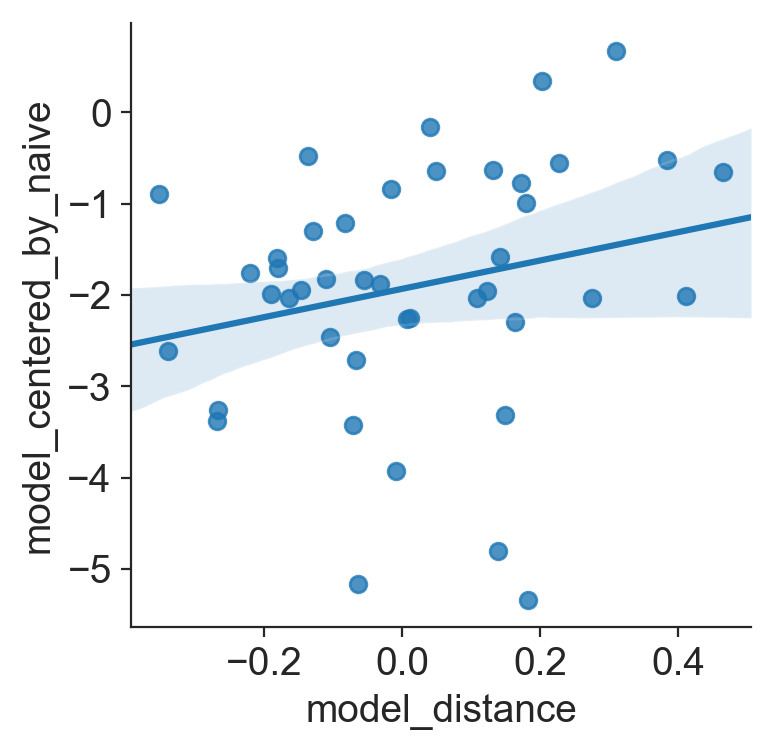

In [571]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.regplot(
    "model_distance",
    "model_centered_by_naive",
    data=values_by_timepoint,
    ax=ax
)

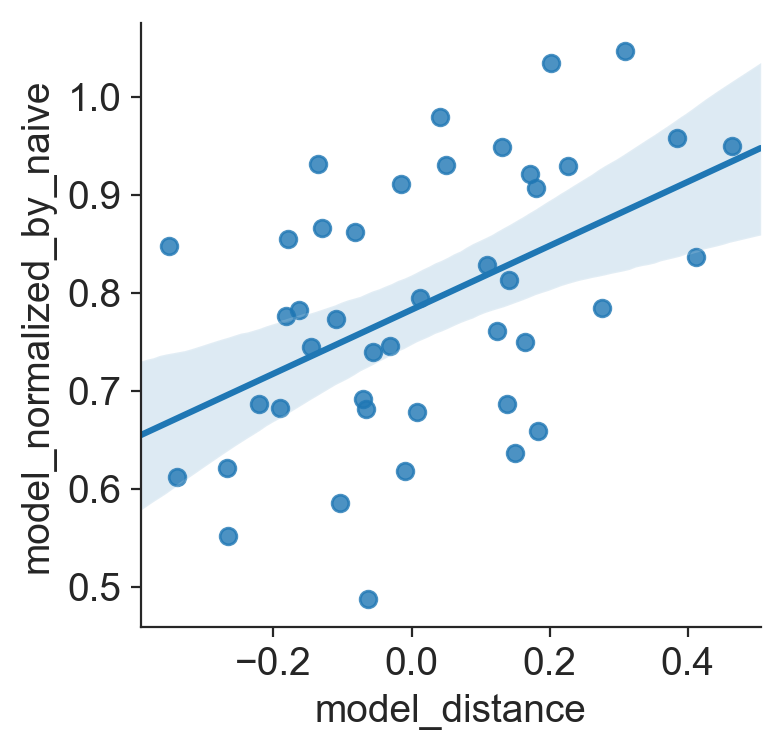

In [572]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.regplot(
    "model_distance",
    "model_normalized_by_naive",
    data=values_by_timepoint,
    ax=ax
)

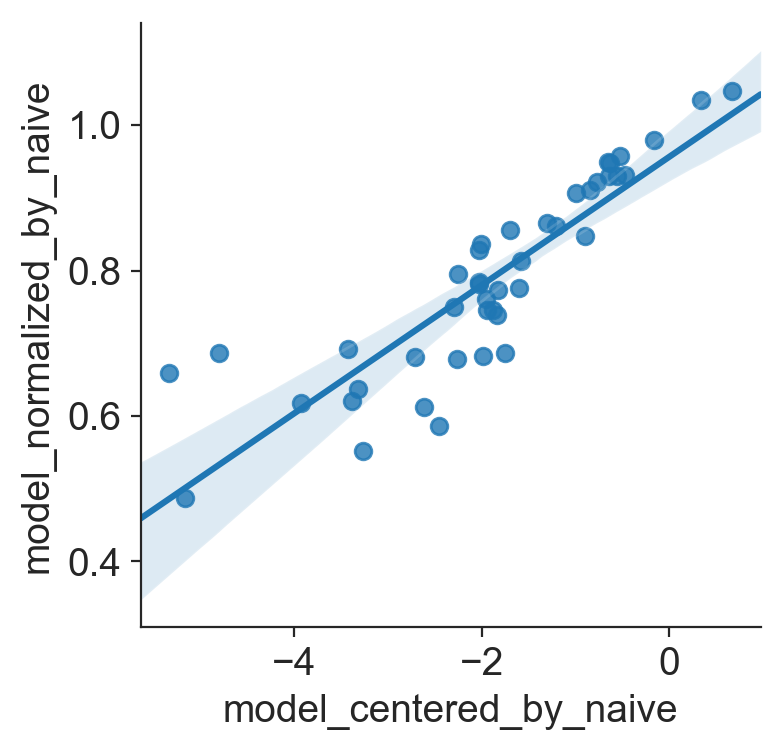

In [573]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.regplot(
    "model_centered_by_naive",
    "model_normalized_by_naive",
    data=values_by_timepoint,
    ax=ax
)

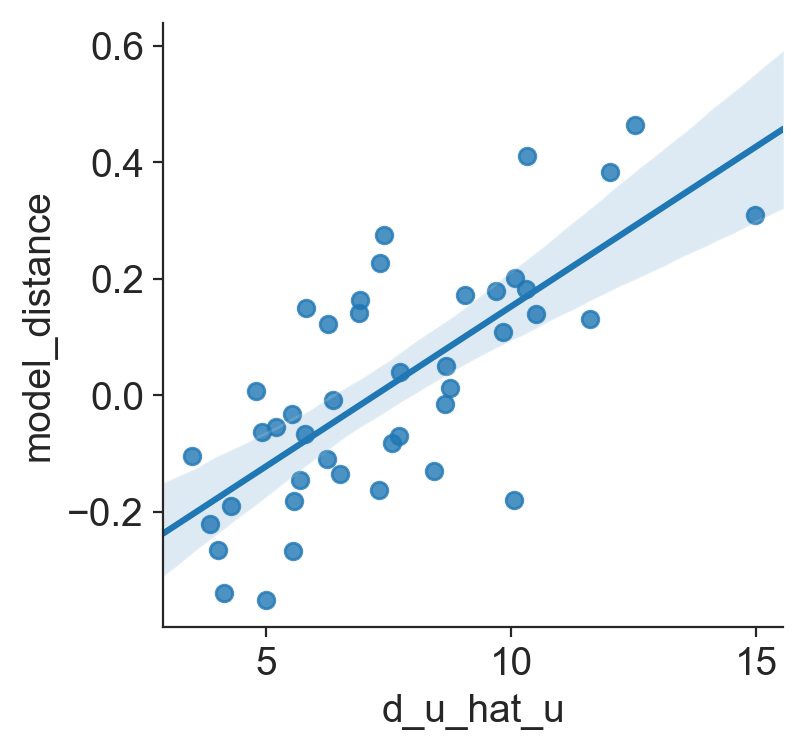

In [580]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.regplot(
    "d_u_hat_u",
    "model_distance",
    data=values_by_timepoint,
    ax=ax
)

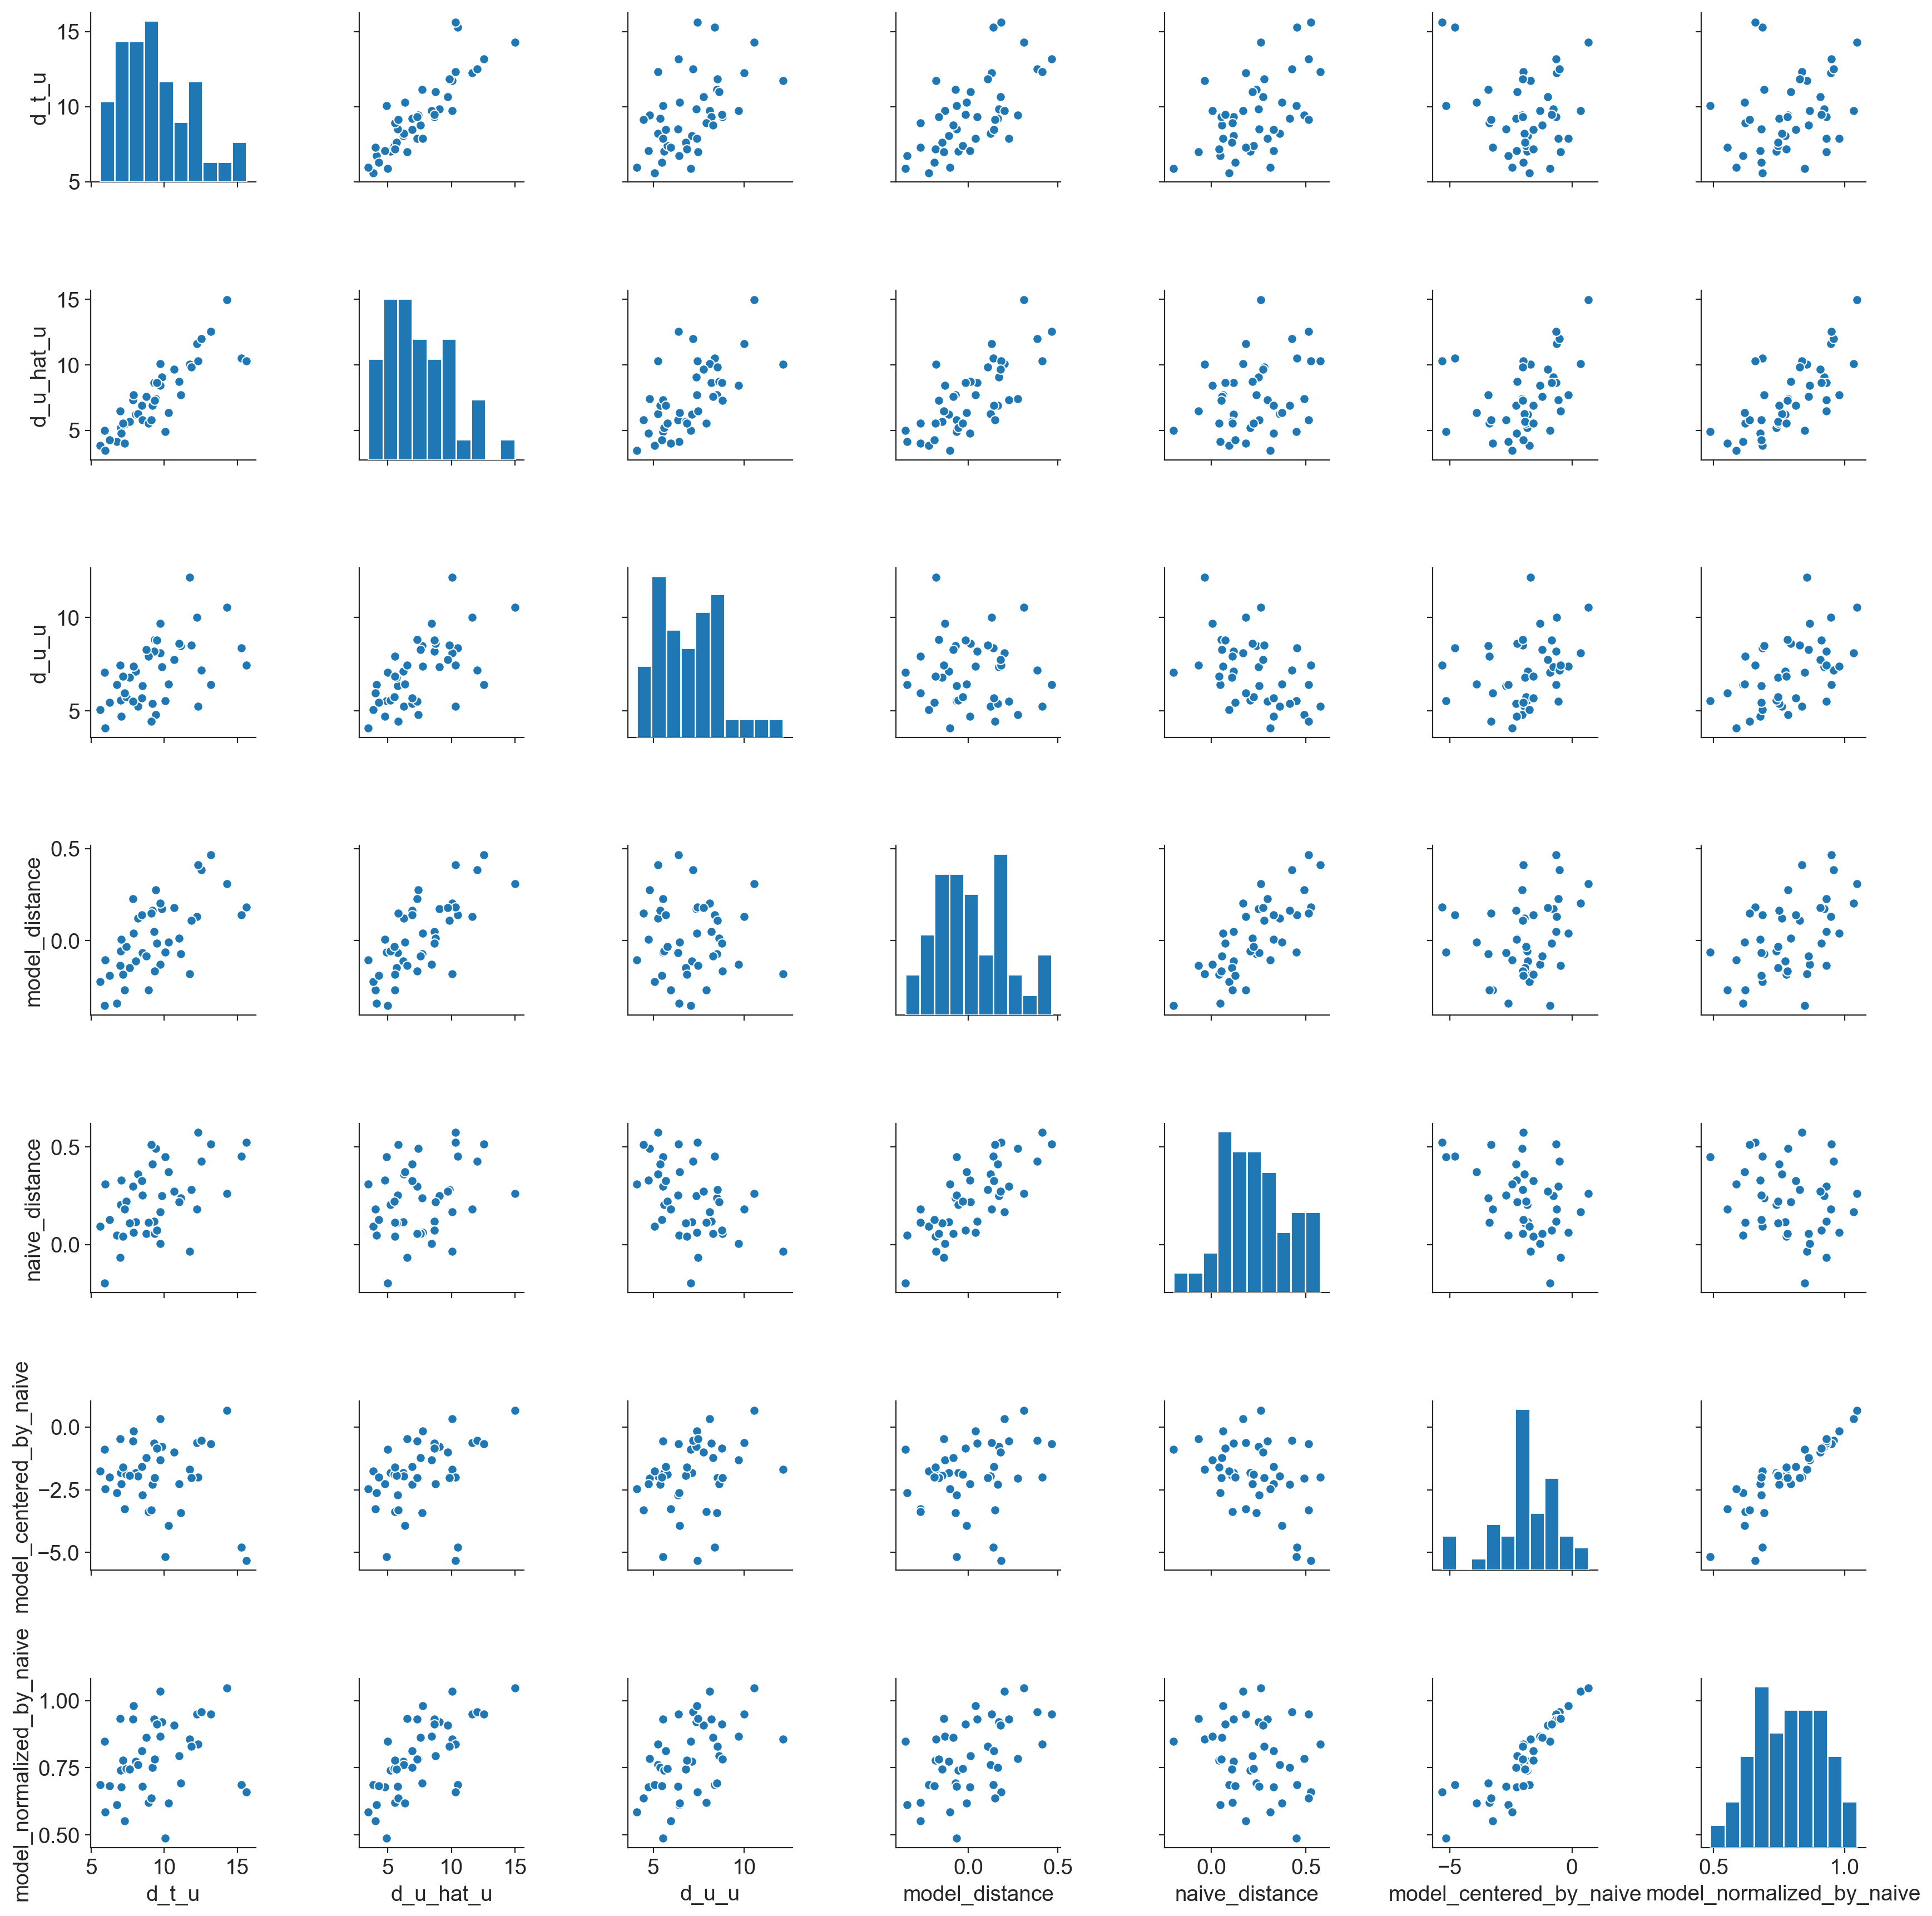

In [581]:
sns.pairplot(values_by_timepoint)

In [567]:
long_values_by_timepoint = values_by_timepoint.melt(id_vars="timepoint", var_name="metric", value_name="metric_value")

In [568]:
long_values_by_timepoint.head()

,timepoint,metric,metric_value
0,1993-10-01,d_t_u,5.890696
1,1994-04-01,d_t_u,9.835388
2,1994-10-01,d_t_u,12.238682
3,1995-04-01,d_t_u,12.531195
4,1995-10-01,d_t_u,15.302754


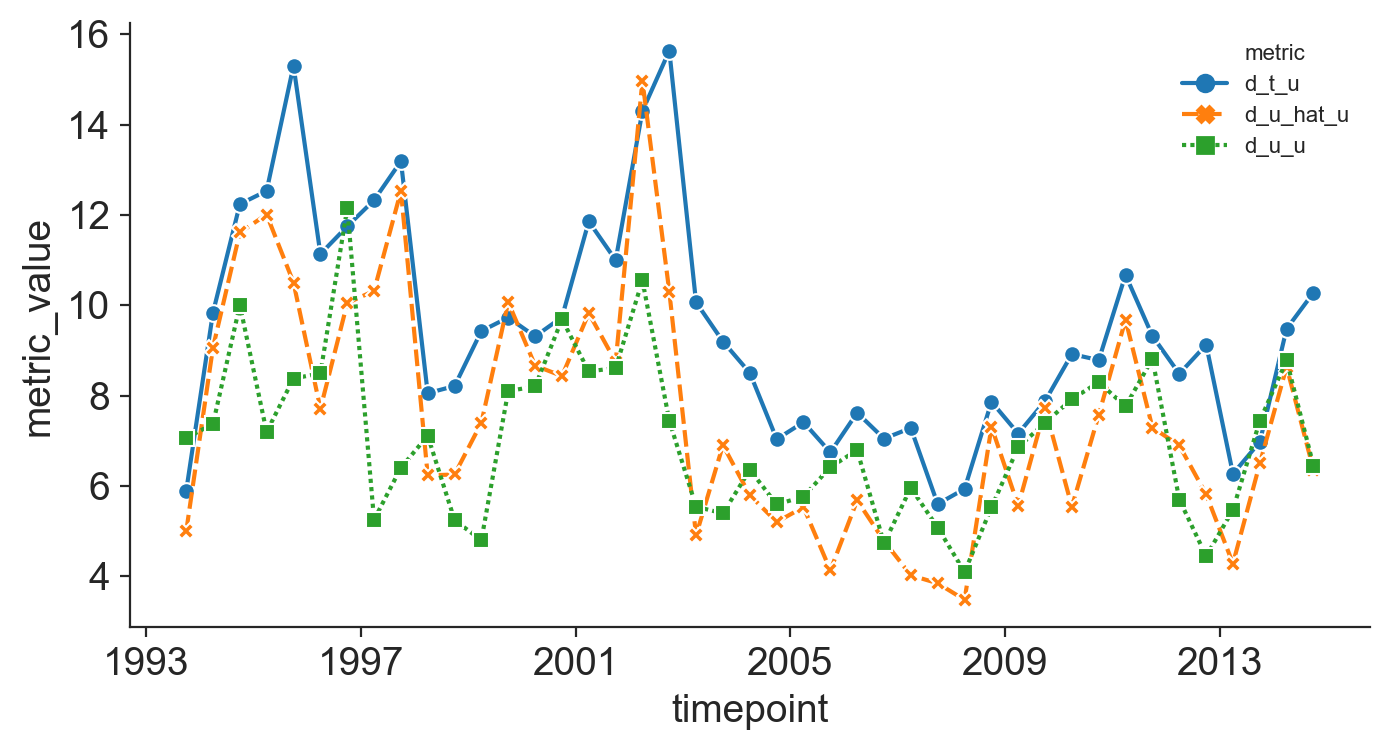

In [576]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.lineplot(
    x="timepoint",
    y="metric_value",
    hue="metric",
    style="metric",
    data=long_values_by_timepoint.query(
        "metric != 'model_distance' & metric != 'naive_distance' & metric != 'model_centered_by_naive' & metric != 'model_normalized_by_naive'"
    ),
    ax=ax,
    markers=True
)
ax.legend(loc="upper right", frameon=False, fontsize=8)

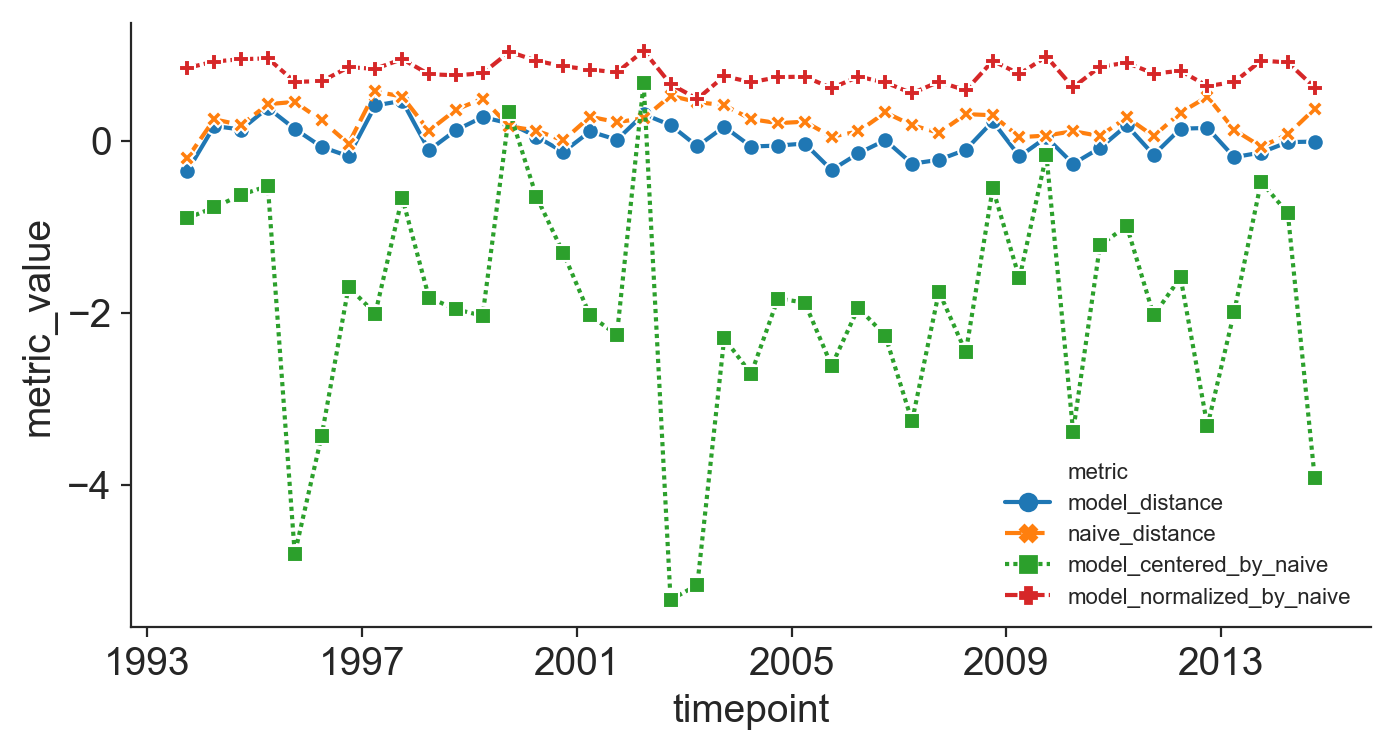

In [578]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.lineplot(
    x="timepoint",
    y="metric_value",
    hue="metric",
    style="metric",
    data=long_values_by_timepoint.query(
        "metric == 'model_distance' | metric == 'naive_distance' | metric == 'model_centered_by_naive' | metric == 'model_normalized_by_naive'"
    ),
    ax=ax,
    markers=True
)
ax.legend(loc="lower right", frameon=False, fontsize=8)

In [652]:
values_by_timepoint.head()

,d_t_u,d_u_hat_u,d_u_u,model_distance,naive_distance,timepoint,model_centered_by_naive,model_normalized_by_naive
0,5.890696,4.992871,7.061616,-0.351189,-0.198775,1993-10-01,-0.897825,0.847586
1,9.835388,9.061510,7.369828,0.172000,0.250682,1994-04-01,-0.773878,0.921317
2,12.238682,11.611282,10.002880,0.131420,0.182683,1994-10-01,-0.627400,0.948736
3,12.531195,12.006846,7.194453,0.384033,0.425877,1995-04-01,-0.524349,0.958157
4,15.302754,10.502533,8.376733,0.138916,0.452600,1995-10-01,-4.800221,0.686317


In [655]:
high_freqs_and_model_distances = high_freqs_by_timepoint.merge(values_by_timepoint, on="timepoint")

In [656]:
high_freqs_and_model_distances.head()

,timepoint,count,sum,proportion,d_t_u,d_u_hat_u,d_u_u,model_distance,naive_distance,model_centered_by_naive,model_normalized_by_naive
0,1993-10-01,54,19.0,0.351852,5.890696,4.992871,7.061616,-0.351189,-0.198775,-0.897825,0.847586
1,1994-04-01,57,26.0,0.456140,9.835388,9.061510,7.369828,0.172000,0.250682,-0.773878,0.921317
2,1994-10-01,56,12.0,0.214286,12.238682,11.611282,10.002880,0.131420,0.182683,-0.627400,0.948736
3,1995-04-01,61,28.0,0.459016,12.531195,12.006846,7.194453,0.384033,0.425877,-0.524349,0.958157
4,1995-10-01,64,5.0,0.078125,15.302754,10.502533,8.376733,0.138916,0.452600,-4.800221,0.686317


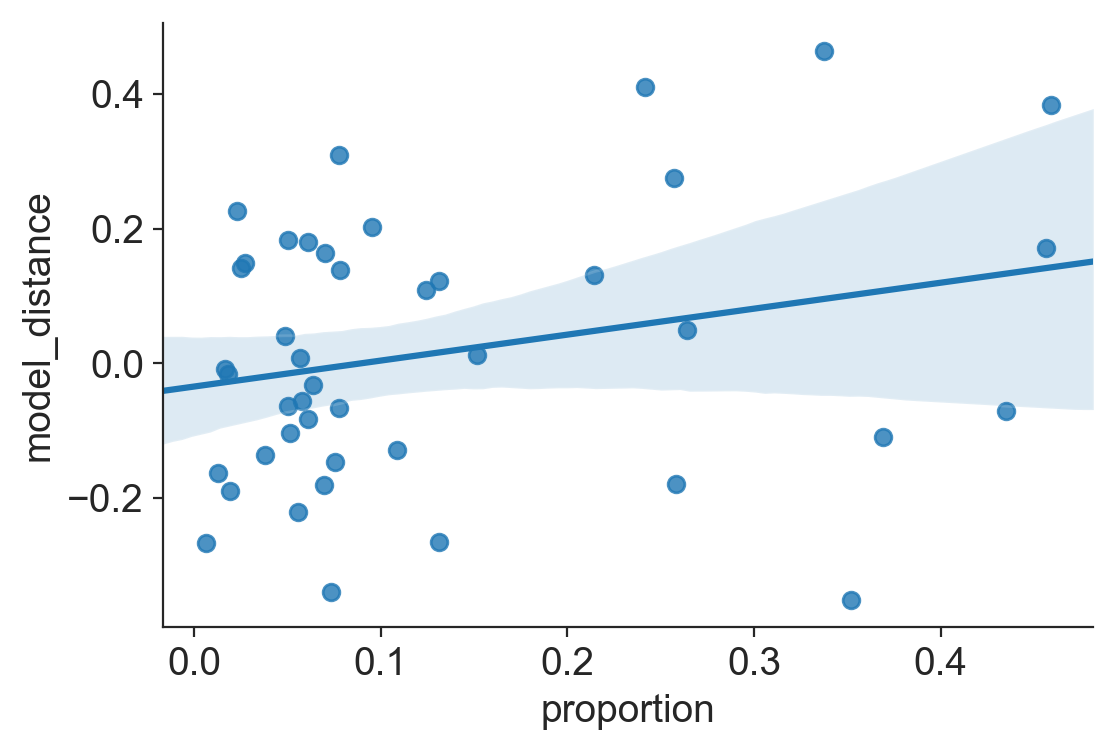

In [658]:
sns.regplot("proportion", "model_distance", high_freqs_and_model_distances)